## Avaliação em holdouts - Amazon Books

Interactions in the 'Amazon Books' dataset are well distributed.
Several users are present during the whole considered period (2014):
<!-- * 37067 users of 190248 (19.484%) occurr in 80.0% or more months. -->
* 2052 users of 16238 (12.637%) occurr in 100% or more months.

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
from recommenders_implicit import ISGD, RAISGD, RSISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateHoldouts, EvaluateAndStore, EvalPrequential # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

from datetime import datetime
import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
## BWT FWT

ACC, BWT, e FWT - Lopez-Paz e Ranzato GEM

In [3]:
def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

___
# Amazon Books
Small subset, ratings only.  
https://nijianmo.github.io/amazon/index.html


In [4]:
# importa dataset 'books playlists'
data = pd.read_csv('output/amazonbooks_dump/3rd_sampled_amazon_books.csv')
dataset_name = 'Amazon_Books'
user_col = 'user_id'
item_col = 'item_id'

In [5]:
data.shape, data.user_id.nunique(), data.item_id.nunique()

((134260, 5), 44358, 105980)

In [6]:
data[['user_id', 'item_id']].duplicated().sum()

594

In [7]:
data.head()

,user_id,item_id,timestamp,date,week
0,0001048767,A2B0MPN8KAS4XJ,1388534400,2014-01-01,1
1,0001050230,A2B0MPN8KAS4XJ,1388534400,2014-01-01,1
2,000171760X,ALDQQWKQ98CMI,1388534400,2014-01-01,1
3,0001720392,A28YHEI6QEU36V,1388534400,2014-01-01,1
4,0001844423,A25YMW02SD1YAO,1388534400,2014-01-01,1


In [8]:
data.tail()

,user_id,item_id,timestamp,date,week
134255,B01FMVUECK,A15O4G1XU0G4LM,1389484800,2014-01-12,2
134256,B01FMVUECK,A19TPOC0G9CP4W,1389484800,2014-01-12,2
134257,B01FMVUECK,A1A2I3546KXE0H,1389484800,2014-01-12,2
134258,B01FMVUECK,A9HZCRVX2150P,1389484800,2014-01-12,2
134259,B01FMVUECK,ASLXJAOPIMSRS,1389484800,2014-01-12,2


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134260 entries, 0 to 134259
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    134260 non-null  object
 1   item_id    134260 non-null  object
 2   timestamp  134260 non-null  int64 
 3   date       134260 non-null  object
 4   week       134260 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 5.1+ MB


### Convert timestamp

In [10]:
%%time 
# 5s
data['date'] = data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

CPU times: user 1.31 s, sys: 56.7 ms, total: 1.37 s
Wall time: 3.65 s


In [11]:
data.head()

,user_id,item_id,timestamp,date,week
0,0001048767,A2B0MPN8KAS4XJ,1388534400,2014-01-01,1
1,0001050230,A2B0MPN8KAS4XJ,1388534400,2014-01-01,1
2,000171760X,ALDQQWKQ98CMI,1388534400,2014-01-01,1
3,0001720392,A28YHEI6QEU36V,1388534400,2014-01-01,1
4,0001844423,A25YMW02SD1YAO,1388534400,2014-01-01,1


CPU times: user 80.4 ms, sys: 4.02 ms, total: 84.4 ms
Wall time: 186 ms


Text(0.5, 1.0, 'interactions per week')

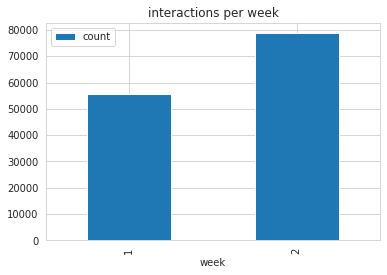

In [12]:
%%time
# 198ms
interactions_per_week = data.groupby(by=['week']).count().iloc[:, 0]
interactions_per_week.name = 'count'
interactions_per_week=interactions_per_week.reset_index()
_ = interactions_per_week.copy()
# _['date'] = _['date'].dt.date
_.groupby('week').sum().plot(kind='bar')
plt.title('interactions per week')

___
## Get intervals and Frequent users (threshold = 0.8)

time intervals

In [13]:
# user_presence_df = pd.read_csv('output/amazonbooks_dump/3rd_sample_user_presence_df.csv')
# user_month_interactions = pd.read_csv('output/amazonbooks_dump/3rd_sample_user_month_interactions.csv')
frequent_users_month = joblib.load('output/amazonbooks_dump/3rd_sample_frequent_users_month.joblib')

___
## Experiments using months

In [14]:
data.shape

(134260, 5)

In [15]:
%%time
# 1min 26s
buckets, holdouts = getBucketsHoldouts(
    data=data, # data[ data['week'] == 1 ].loc[:20000],#
    user_col=user_col,
    item_col=item_col,
    frequent_users=data['user_id'].unique(), #frequent_users_month, # to use every user in holdout: data['user_id'].unique()
    interval_type='W',
    intervals=None, 
    cold_start_buckets=0)

Creating buckets. . .
Creating holdouts. . .
Cleaning holdouts. . .
common interactions between holdout 1 and all buckets: 81
common interactions between holdout 2 and all buckets: 119
Converting to ImplicitData. . .
Done!
CPU times: user 9min 10s, sys: 572 ms, total: 9min 11s
Wall time: 31min 30s


In [16]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

134260

In [17]:
joblib.dump(buckets, 'output/amazonbooks_dump/3rd_sample_buckets.joblib')
joblib.dump(holdouts, 'output/amazonbooks_dump/3rd_sample_holdouts.joblib')

['output/amazonbooks_dump/3rd_sample_holdouts.joblib']

### ISGD

In [18]:
buckets = joblib.load('output/amazonbooks_dump/3rd_sample_buckets.joblib')
holdouts = joblib.load('output/amazonbooks_dump/3rd_sample_holdouts.joblib')

Hyperparameters

In [19]:
%%time
import itertools
def grid_search(model, stream, random_seed = 10, interleaved=10):    
    num_factors = [100, 150, 200]
    num_iter = [2, 5, 8]
    learn_rate = [0.1, 0.25, 0.5]
    regularization = [0.3, 0.4, 0.5]
    num_nodes = [4, 8, 16]
    grid = [num_factors, num_iter, learn_rate, regularization, num_nodes]
    grid = list(itertools.product(*grid))
    results = []
    for i, hp in enumerate(grid):
        print(((i*100)/len(grid)), '%')
        empty_stream = ImplicitData([], [])
        nf, ni, lr, reg, nn = hp
        m = model(empty_stream, nf, ni, lr, reg, reg, random_seed)
        e = EvalPrequential(m, stream, metrics = ["Recall@N"])
        result = e.Evaluate(start_eval=0, count=stream.size, interleaved=interleaved)
        results.append( np.mean(result['Recall@N']) )
    return grid, results    
prop = 0.05
hp_sample = data.iloc[:round( data.shape[0]*prop )]
stream = ImplicitData(hp_sample[user_col], hp_sample[item_col]) #(data['playlist_id'],data['track_id'])    

# 6h 25min 45s
grid, results = grid_search(model=ISGD, stream=stream, random_seed=10, interleaved=1 )
len(grid), len(results), max(results) # (243, 243, 0.006805807622504537)

0.0 %


/home/kpereira/streamRec-forgetting/notebooks/../recommenders_implicit/ISGD.py:119: RuntimeWarning: overflow encountered in multiply
  delta = self.learn_rate * (err * p_u - self.item_regularization * q_i)
/home/kpereira/streamRec-forgetting/notebooks/../recommenders_implicit/ISGD.py:119: RuntimeWarning: invalid value encountered in subtract
  delta = self.learn_rate * (err * p_u - self.item_regularization * q_i)
/home/kpereira/streamRec-forgetting/notebooks/../recommenders_implicit/ISGD.py:112: RuntimeWarning: overflow encountered in multiply
  delta = self.learn_rate * (err * q_i - self.user_regularization * p_u)
/home/kpereira/streamRec-forgetting/notebooks/../recommenders_implicit/ISGD.py:113: RuntimeWarning: invalid value encountered in add
  p_u += delta


CPU times: user 8h 10min 22s, sys: 21h 5min 40s, total: 1d 5h 16min 3s
Wall time: 5h 40min 53s


(243, 243, 0.006805807622504537)

In [21]:
# num_factors, num_iter, learn_rate, regularization, num_nodes = grid[ np.argmax( results ) ]
num_factors, num_iter, learn_rate, regularization, num_nodes = grid[ np.argmax( results ) ] # (100, 8, 0.5, 0.3, 4)

In [22]:
# # define hyperparameters (SAME AS LASTFM)
# num_factors = 160
# num_iter = 4
# learn_rate = 0.5
# regularization = 0.4
# num_nodes = 8

In [23]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [24]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

CPU times: user 7 µs, sys: 34 µs, total: 41 µs
Wall time: 51 µs


In [25]:
%%time
# 4h 36min 18s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True, default_user='none')

----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
Test Holdout 1
recommendations not made for users in holdout 1 x checkpoint 0: 4020
----------------------------------------------------------------------------------------------------
Train bucket 1
Test Holdout 0
Test Holdout 1
CPU times: user 6h 24s, sys: 6h 59min 22s, total: 12h 59min 46s
Wall time: 4h 36min 18s


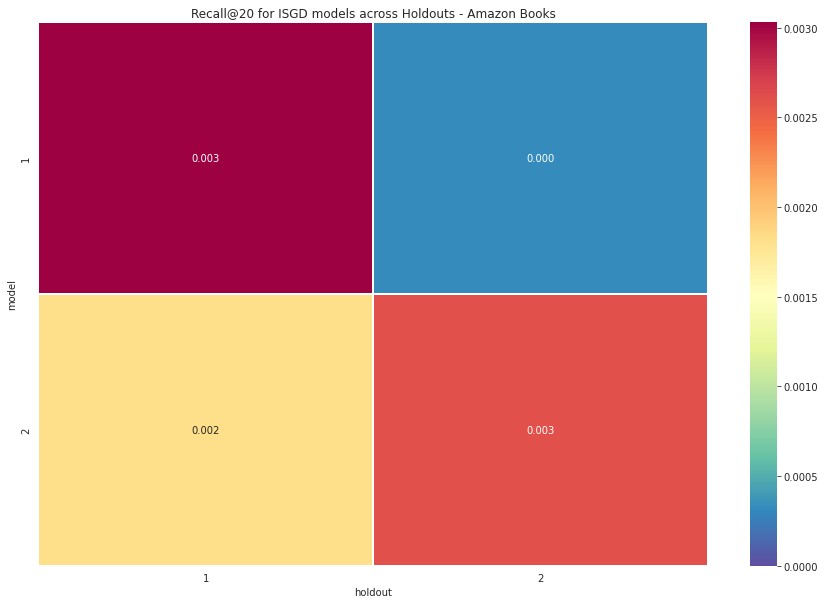

In [27]:
rm = eval.results_matrix
df = pd.DataFrame(rm)
df.to_csv('output/amazonbooks_dump/3rd_sample_amazon_books month_bucket ISGD results.csv', index=False)
recall_heatmap(df, 
               round_point=3,
               title='Recall@20 for ISGD models across Holdouts - Amazon Books',
               filepath='images/heatmaps/amazonbooks_dump/3rd_sample_amazon_books month_bucket ISGD heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [28]:
arecall = avg_recall(df)
arecall

0.0028227783245421004

In [29]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([-0.0012121212121212121], -0.0012121212121212121)

In [30]:
FWT = compute_FWT(df)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.00032200933827080985

In [31]:
joblib.dump(eval.IncrementalTraining_time_record, 'output/amazonbooks_dump/3rd_sample_amazon_books month_bucket ISGD training time.joblib')
joblib.dump(eval.EvaluateHoldouts_time_record, 'output/amazonbooks_dump/3rd_sample_amazon_books month_bucket ISGD eval time.joblib')

['output/amazonbooks_dump/3rd_sample_amazon_books month_bucket ISGD eval time.joblib']